In [1]:
import numpy as np
import pandas as pd
import requests

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_validate
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import (
    LogisticRegression,
    PassiveAggressiveClassifier
)
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve
)


In [2]:
df = pd.read_csv('DataFix_Preprocessed.csv', encoding='utf-8')
df['sentiment'] = df['Rating'].apply(
    lambda r: 'negatif' if r<=2 else ('netral' if r==3 else 'positif')
)
X = df['text_clean'].fillna('')
y = df['sentiment']

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=36
)

train_df = pd.DataFrame({'text': X_tr, 'sentiment': y_tr})
max_n = train_df['sentiment'].value_counts().max()
parts = [
    grp.sample(max_n, replace=True, random_state=36)
    if len(grp)<max_n else grp
    for _, grp in train_df.groupby('sentiment')
]
train_bal = pd.concat(parts)
X_tr_bal = train_bal['text'].tolist()
y_tr_bal = train_bal['sentiment'].tolist()

=== MultinomialNB CV Metrics ===
accuracy       : 0.860 ± 0.003
precision_macro: 0.872 ± 0.002
recall_macro   : 0.860 ± 0.003
f1_macro       : 0.852 ± 0.004

=== MultinomialNB Test ===
              precision    recall  f1-score   support

     negatif      0.107     0.630     0.183        27
      netral      0.924     0.623     0.744       743
     positif      0.623     0.846     0.717       306

    accuracy                          0.687      1076
   macro avg      0.551     0.700     0.548      1076
weighted avg      0.818     0.687     0.723      1076



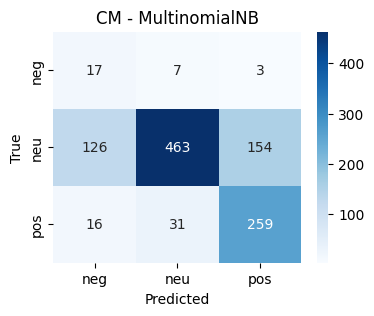

In [3]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('clf', MultinomialNB())
])
cv = StratifiedKFold(5, shuffle=True, random_state=28)
scoring = ['accuracy','precision_macro','recall_macro','f1_macro']
cv_res = cross_validate(pipe, X_tr_bal, y_tr_bal, cv=cv,
                        scoring=scoring, n_jobs=-1)
print("=== MultinomialNB CV Metrics ===")
for m in scoring:
    s = cv_res[f'test_{m}']
    print(f"{m:15s}: {s.mean():.3f} ± {s.std():.3f}")

pipe.fit(X_tr_bal, y_tr_bal)
preds = pipe.predict(X_te)

print("\n=== MultinomialNB Test ===")
print(classification_report(y_te, preds, zero_division=0, digits=3))

cm = confusion_matrix(y_te, preds, labels=['negatif','netral','positif'])
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['neg','neu','pos'], yticklabels=['neg','neu','pos'])
plt.title('CM - MultinomialNB')
plt.ylabel('True'); plt.xlabel('Predicted')
plt.show()

In [4]:
orig = df.loc[X_te.index, 'text']
err_mask = preds != y_te
errors = pd.DataFrame({
    'text_asli': orig[err_mask],
    'actual':    y_te[err_mask].values,
    'pred':      preds[err_mask]
})
print("\nMultinomialNB – 10 Contoh Salah Prediksi:")
print(errors.head(10).to_string(index=False))



MultinomialNB – 10 Contoh Salah Prediksi:
                                                text_asli  actual    pred
                                   coba lagi taun depan,,  netral negatif
                                          @michaeladhi 🔥🔥  netral positif
Semoga semua peserta sehat n finish strong .. Amiinn 💛💛💛💛  netral positif
                 Aahhhh sedih tahun ini ga kebagian slot😢  netral negatif
              Makasih mimin baca ini langsung siap2 lari😁 positif  netral
                                     @dllqdr_ bismillah 😇  netral positif
                       @pocarisportid menyala pocariiii🔥🙌  netral positif
                          Yeayy ada kuch @agunggantar 👏👏👏  netral positif
                                            @elylbaedlowi  netral negatif
                                                  AKUUU 🙌  netral positif


=== ComplementNB CV Metrics ===
accuracy       : 0.853 ± 0.004
precision_macro: 0.871 ± 0.003
recall_macro   : 0.853 ± 0.004
f1_macro       : 0.844 ± 0.005

=== ComplementNB Test ===
              precision    recall  f1-score   support

     negatif      0.100     0.593     0.171        27
      netral      0.931     0.615     0.741       743
     positif      0.619     0.859     0.720       306

    accuracy                          0.684      1076
   macro avg      0.550     0.689     0.544      1076
weighted avg      0.821     0.684     0.720      1076



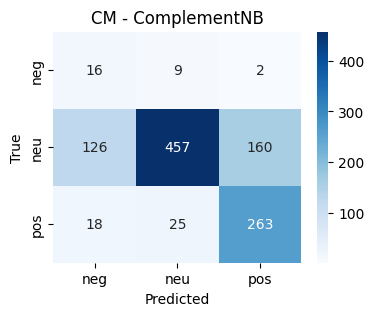

In [5]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('clf', ComplementNB())
])
cv = StratifiedKFold(5, shuffle=True, random_state=28)
scoring = ['accuracy','precision_macro','recall_macro','f1_macro']
cv_res = cross_validate(pipe, X_tr_bal, y_tr_bal, cv=cv,
                        scoring=scoring, n_jobs=-1)
print("=== ComplementNB CV Metrics ===")
for m in scoring:
    s = cv_res[f'test_{m}']
    print(f"{m:15s}: {s.mean():.3f} ± {s.std():.3f}")

pipe.fit(X_tr_bal, y_tr_bal)
preds = pipe.predict(X_te)

print("\n=== ComplementNB Test ===")
print(classification_report(y_te, preds, zero_division=0, digits=3))

cm = confusion_matrix(y_te, preds, labels=['negatif','netral','positif'])
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['neg','neu','pos'], yticklabels=['neg','neu','pos'])
plt.title('CM - ComplementNB')
plt.ylabel('True'); plt.xlabel('Predicted')
plt.show()

In [6]:
orig = df.loc[X_te.index, 'text']
errors = pd.DataFrame({
    'text_asli': orig[preds!=y_te],
    'actual':    y_te[preds!=y_te].values,
    'pred':      preds[preds!=y_te]
})
print("\nComplementNB – 10 Contoh Salah Prediksi:")
print(errors.head(10).to_string(index=False))



ComplementNB – 10 Contoh Salah Prediksi:
                                                                                                      text_asli  actual    pred
                                                                                         coba lagi taun depan,,  netral negatif
                                                                                                @michaeladhi 🔥🔥  netral positif
                                                      Semoga semua peserta sehat n finish strong .. Amiinn 💛💛💛💛  netral positif
                                                                       Aahhhh sedih tahun ini ga kebagian slot😢  netral negatif
                                                                    Makasih mimin baca ini langsung siap2 lari😁 positif  netral
                                                                                           @dllqdr_ bismillah 😇  netral positif
                                                              

=== LogisticRegression CV Metrics ===
accuracy       : 0.912 ± 0.006
precision_macro: 0.913 ± 0.006
recall_macro   : 0.912 ± 0.006
f1_macro       : 0.912 ± 0.006

=== LogisticRegression Test ===
              precision    recall  f1-score   support

     negatif      0.040     0.037     0.038        27
      netral      0.881     0.809     0.844       743
     positif      0.669     0.807     0.732       306

    accuracy                          0.789      1076
   macro avg      0.530     0.551     0.538      1076
weighted avg      0.800     0.789     0.792      1076



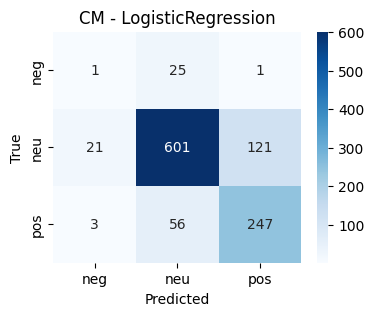

In [7]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=28))
])
cv = StratifiedKFold(5, shuffle=True, random_state=28)
scoring = ['accuracy','precision_macro','recall_macro','f1_macro']
cv_res = cross_validate(pipe, X_tr_bal, y_tr_bal, cv=cv,
                        scoring=scoring, n_jobs=-1)
print("=== LogisticRegression CV Metrics ===")
for m in scoring:
    s = cv_res[f'test_{m}']
    print(f"{m:15s}: {s.mean():.3f} ± {s.std():.3f}")

pipe.fit(X_tr_bal, y_tr_bal)
preds = pipe.predict(X_te)

print("\n=== LogisticRegression Test ===")
print(classification_report(y_te, preds, zero_division=0, digits=3))

cm = confusion_matrix(y_te, preds, labels=['negatif','netral','positif'])
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['neg','neu','pos'], yticklabels=['neg','neu','pos'])
plt.title('CM - LogisticRegression')
plt.ylabel('True'); plt.xlabel('Predicted')
plt.show()


In [8]:
orig = df.loc[X_te.index, 'text']
errors = pd.DataFrame({
    'text_asli': orig[preds!=y_te],
    'actual':    y_te[preds!=y_te].values,
    'pred':      preds[preds!=y_te]
})
print("\nLogisticRegression – 10 Contoh Salah Prediksi:")
print(errors.head(10).to_string(index=False))


LogisticRegression – 10 Contoh Salah Prediksi:
                                                                                                                                                                                                                                                                                         text_asli  actual    pred
                                                                                                                                                                                                                                                                                   @michaeladhi 🔥🔥  netral positif
                                                                                                                                                                                                                                         Semoga semua peserta sehat n finish strong .. Amiinn 💛💛💛💛  netral positif
                               

=== LinearSVC CV Metrics ===
accuracy       : 0.939 ± 0.004
precision_macro: 0.942 ± 0.003
recall_macro   : 0.939 ± 0.003
f1_macro       : 0.938 ± 0.004

=== LinearSVC Test ===
              precision    recall  f1-score   support

     negatif      0.000     0.000     0.000        27
      netral      0.881     0.833     0.856       743
     positif      0.676     0.810     0.737       306

    accuracy                          0.806      1076
   macro avg      0.519     0.548     0.531      1076
weighted avg      0.800     0.806     0.801      1076



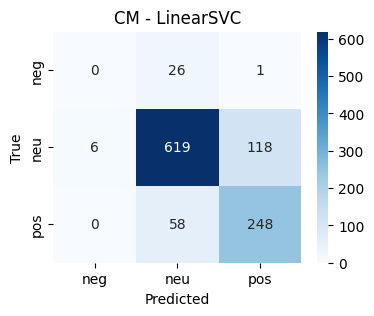

In [9]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('clf', LinearSVC(class_weight='balanced', random_state=28))
])
cv = StratifiedKFold(5, shuffle=True, random_state=28)
scoring = ['accuracy','precision_macro','recall_macro','f1_macro']
cv_res = cross_validate(pipe, X_tr_bal, y_tr_bal, cv=cv,
                        scoring=scoring, n_jobs=-1)
print("=== LinearSVC CV Metrics ===")
for m in scoring:
    s = cv_res[f'test_{m}']
    print(f"{m:15s}: {s.mean():.3f} ± {s.std():.3f}")

pipe.fit(X_tr_bal, y_tr_bal)
preds = pipe.predict(X_te)

print("\n=== LinearSVC Test ===")
print(classification_report(y_te, preds, zero_division=0, digits=3))

cm = confusion_matrix(y_te, preds, labels=['negatif','netral','positif'])
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['neg','neu','pos'], yticklabels=['neg','neu','pos'])
plt.title('CM - LinearSVC')
plt.ylabel('True'); plt.xlabel('Predicted')
plt.show()

In [10]:
orig = df.loc[X_te.index, 'text']
errors = pd.DataFrame({
    'text_asli': orig[preds!=y_te],
    'actual':    y_te[preds!=y_te].values,
    'pred':      preds[preds!=y_te]
})
print("\nLinearSVC – 10 Contoh Salah Prediksi:")
print(errors.head(10).to_string(index=False))


LinearSVC – 10 Contoh Salah Prediksi:
                                                                                                                                                                                                                                                                                         text_asli  actual    pred
                                                                                                                                                                                                                                                                                   @michaeladhi 🔥🔥  netral positif
                                                                                                                                                                                                                                         Semoga semua peserta sehat n finish strong .. Amiinn 💛💛💛💛  netral positif
                                        

=== PassiveAggressive CV Metrics ===
accuracy       : 0.943 ± 0.002
precision_macro: 0.946 ± 0.002
recall_macro   : 0.943 ± 0.002
f1_macro       : 0.943 ± 0.002

=== PassiveAggressive Test ===
              precision    recall  f1-score   support

     negatif      0.000     0.000     0.000        27
      netral      0.882     0.843     0.862       743
     positif      0.678     0.810     0.738       306

    accuracy                          0.812      1076
   macro avg      0.520     0.551     0.533      1076
weighted avg      0.802     0.812     0.805      1076



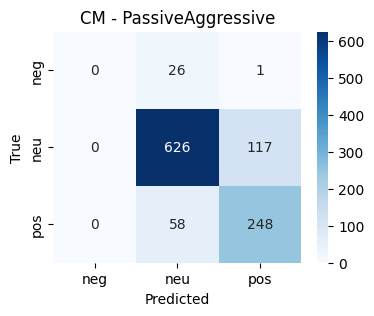

In [11]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('clf', PassiveAggressiveClassifier(max_iter=1000, random_state=28))
])
cv = StratifiedKFold(5, shuffle=True, random_state=28)
scoring = ['accuracy','precision_macro','recall_macro','f1_macro']
cv_res = cross_validate(pipe, X_tr_bal, y_tr_bal, cv=cv,
                        scoring=scoring, n_jobs=-1)
print("=== PassiveAggressive CV Metrics ===")
for m in scoring:
    s = cv_res[f'test_{m}']
    print(f"{m:15s}: {s.mean():.3f} ± {s.std():.3f}")

pipe.fit(X_tr_bal, y_tr_bal)
preds = pipe.predict(X_te)

print("\n=== PassiveAggressive Test ===")
print(classification_report(y_te, preds, zero_division=0, digits=3))

cm = confusion_matrix(y_te, preds, labels=['negatif','netral','positif'])
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['neg','neu','pos'], yticklabels=['neg','neu','pos'])
plt.title('CM - PassiveAggressive')
plt.ylabel('True'); plt.xlabel('Predicted')
plt.show()


In [12]:
orig = df.loc[X_te.index, 'text']
errors = pd.DataFrame({
    'text_asli': orig[preds!=y_te],
    'actual':    y_te[preds!=y_te].values,
    'pred':      preds[preds!=y_te]
})
print("\nPassiveAggressive – 10 Contoh Salah Prediksi:")
print(errors.head(10).to_string(index=False))


PassiveAggressive – 10 Contoh Salah Prediksi:
                                                                                                                                                                                                                                                                                         text_asli  actual    pred
                                                                                                                                                                                                                                                                                   @michaeladhi 🔥🔥  netral positif
                                                                                                                                                                                                                                         Semoga semua peserta sehat n finish strong .. Amiinn 💛💛💛💛  netral positif
                                

# Optimisasi

Lexicon loaded.

=== MultinomialNB ===
Optimal threshold for 'negatif': 0.853
Classification Report:
              precision    recall  f1-score   support

     negatif      0.127     0.296     0.178        27
      netral      0.910     0.764     0.831       743
     positif      0.671     0.853     0.751       306

    accuracy                          0.778      1076
   macro avg      0.569     0.638     0.587      1076
weighted avg      0.823     0.778     0.792      1076



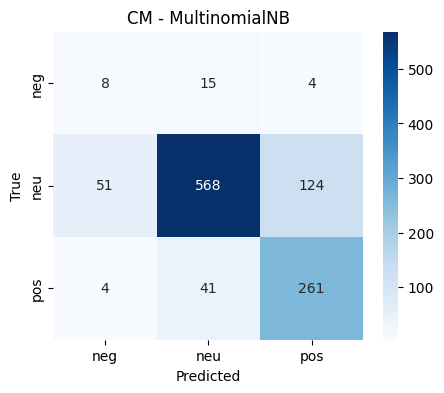

MultinomialNB – 10 Contoh Salah Prediksi:
                                                                                                                                                                                                                                                                                                 text_asli  actual    pred
                                                                                                                                                                                                                                                Waaahh...semangaat masbrooo @arimasrudy 🔥🔥 ratakan gianyar positif  netral
                                                                                                                                                                                                                                                                                          @mohammadrafi.ab  netral negatif
             

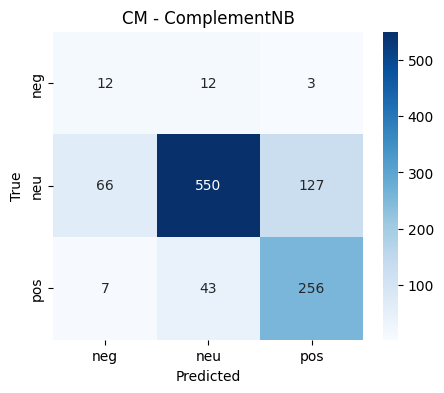

ComplementNB – 10 Contoh Salah Prediksi:
                                                                            text_asli  actual    pred
                           Waaahh...semangaat masbrooo @arimasrudy 🔥🔥 ratakan gianyar positif  netral
                                                                     @mohammadrafi.ab  netral negatif
                                                  @sambas_a thankyouuu abas @sambas_a  netral positif
                                          Wihh pak @purnama_jaya menyala wiiii 🔥🔥🔥👏👏👏  netral positif
                                                                   @fitrivivi_ gassss  netral positif
@kangdhesu dijamin cheering bukan dengan suara klakson tapi suara warga yang excited🙌 positif negatif
                                                        selamat bertugas para pacer 🔥 positif  netral
                                                                         Gagahnyoo 🫵🤩  netral positif
                          Dalam nama Tuha

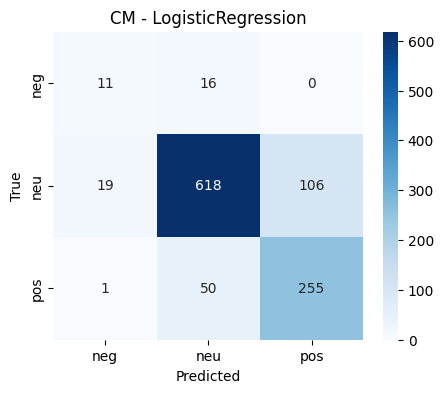

LogisticRegression – 10 Contoh Salah Prediksi:
                                                                                                                                                                                                                                                                                                 text_asli  actual    pred
                                                                                                                                                                                                                                                Waaahh...semangaat masbrooo @arimasrudy 🔥🔥 ratakan gianyar positif  netral
                                                                                                                                                                                                                                                               Wihh pak @purnama_jaya menyala wiiii 🔥🔥🔥👏👏👏  netral positif
        

In [13]:
try:
    import requests
    neg_words = set(requests.get(
        'https://raw.githubusercontent.com/masdevid/ID-OpinionWords/master/negative.txt',
        timeout=5).text.splitlines())
    pos_words = set(requests.get(
        'https://raw.githubusercontent.com/masdevid/ID-OpinionWords/master/positive.txt',
        timeout=5).text.splitlines())
    print("Lexicon loaded.")
except:
    neg_words = set()
    pos_words = set()
    print("Using empty lexica.")

class LexiconCount(TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        rows = []
        for doc in X:
            toks = doc.split()
            rows.append([sum(w in neg_words for w in toks),
                         sum(w in pos_words for w in toks)])
        return np.array(rows)

df = pd.read_csv('DataFix_Preprocessed.csv', encoding='utf-8')
df['sentiment'] = df['Rating'].apply(
    lambda r: 'negatif' if r<=2 else ('netral' if r==3 else 'positif')
)
X = df['text_clean'].fillna('')
y = df['sentiment']

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=28
)
train_df = pd.DataFrame({'text': X_tr, 'sentiment': y_tr})
max_n = train_df['sentiment'].value_counts().max()
parts = []
for cls, grp in train_df.groupby('sentiment'):
    if len(grp) < max_n:
        grp = grp.sample(max_n, replace=True, random_state=28)
    parts.append(grp)
train_bal = pd.concat(parts)
X_tr_bal = train_bal['text'].tolist()
y_tr_bal = train_bal['sentiment'].tolist()

features = FeatureUnion([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('lex',  LexiconCount())
])

def tune_threshold(pipe, X_train, y_train, X_val, y_val):
    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X_val)
    neg_idx = list(pipe.classes_).index('negatif')
    y_bin = (y_val == 'negatif').astype(int)
    prec, rec, thr = precision_recall_curve(y_bin, proba[:, neg_idx])
    f1 = 2 * prec * rec / (prec + rec + 1e-9)
    return thr[np.nanargmax(f1)]

model_defs = {
    'MultinomialNB': MultinomialNB(alpha=0.1, class_prior=[1/3]*3),
    'ComplementNB':  ComplementNB(alpha=0.1, class_prior=[1/3]*3),
    'LogisticRegression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=28)
}

for name, clf in model_defs.items():
    print(f"\n=== {name} ===")
    pipe = Pipeline([('feat', features), ('clf', clf)])
    
    best_t = tune_threshold(pipe, X_tr_bal, y_tr_bal, X_te, y_te)
    print(f"Optimal threshold for 'negatif': {best_t:.3f}")
    
    pipe.fit(X_tr_bal, y_tr_bal)
    proba = pipe.predict_proba(X_te)
    neg_idx = list(pipe.classes_).index('negatif')
    preds = np.where(
        proba[:, neg_idx] >= best_t,
        'negatif',
        pipe.classes_[np.argmax(proba, axis=1)]
    )

    print("Classification Report:")
    print(classification_report(y_te, preds, zero_division=0, digits=3))

    cm = confusion_matrix(y_te, preds, labels=['negatif','netral','positif'])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['neg','neu','pos'], yticklabels=['neg','neu','pos'])
    plt.title(f'CM - {name}')
    plt.ylabel('True'); plt.xlabel('Predicted'); plt.show()

    orig = df.loc[X_te.index, 'text']
    mask = preds != y_te
    errors = pd.DataFrame({
        'text_asli': orig[mask],
        'actual':    y_te[mask].values,
        'pred':      preds[mask]
    })
    print(f"{name} – 10 Contoh Salah Prediksi:")
    print(errors.head(10).to_string(index=False))


# Esemble Learning

Optimal threshold for ‘negatif’: 0.170

=== Stacked Ensemble (MNB+CNB+LR) ===
              precision    recall  f1-score   support

     negatif      0.400     0.519     0.452        27
      netral      0.898     0.865     0.881       743
     positif      0.754     0.801     0.777       306

    accuracy                          0.838      1076
   macro avg      0.684     0.728     0.703      1076
weighted avg      0.845     0.838     0.841      1076



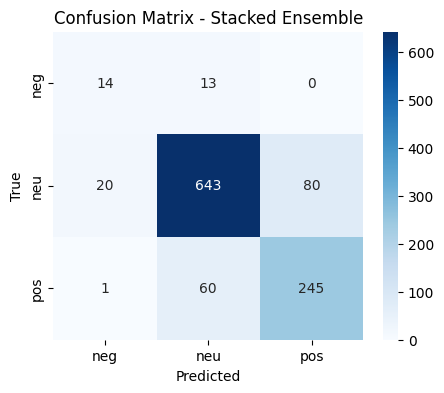

10 Contoh Salah Prediksi:
                                                                                                                                                                                                                                                                                                 text_asli  actual    pred
                                                                                                                                                                                                                                                Waaahh...semangaat masbrooo @arimasrudy 🔥🔥 ratakan gianyar positif  netral
                                                                                                                                                                                                                                                               Wihh pak @purnama_jaya menyala wiiii 🔥🔥🔥👏👏👏  netral positif
                             

In [14]:
try:
    neg_url = 'https://raw.githubusercontent.com/masdevid/ID-OpinionWords/master/negative.txt'
    pos_url = 'https://raw.githubusercontent.com/masdevid/ID-OpinionWords/master/positive.txt'
    neg_words = set(requests.get(neg_url, timeout=5).text.splitlines())
    pos_words = set(requests.get(pos_url, timeout=5).text.splitlines())
except:
    neg_words = set()
    pos_words = set()

class LexiconCount(TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        rows = []
        for doc in X:
            toks = doc.split()
            rows.append([
                sum(w in neg_words for w in toks),
                sum(w in pos_words for w in toks)
            ])
        return np.array(rows)

df = pd.read_csv('DataFix_Preprocessed.csv', encoding='utf-8')
df['sentiment'] = df['Rating'].apply(lambda r:
    'negatif' if r<=2 else ('netral' if r==3 else 'positif')
)
X = df['text_clean'].fillna('')
y = df['sentiment']

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=28
)
train_df = pd.DataFrame({'text': X_tr, 'sentiment': y_tr})
max_n = train_df['sentiment'].value_counts().max()
parts = []
for cls, grp in train_df.groupby('sentiment'):
    if len(grp) < max_n:
        grp = grp.sample(max_n, replace=True, random_state=28)
    parts.append(grp)
train_bal = pd.concat(parts)
X_tr_bal = train_bal['text'].tolist()
y_tr_bal = train_bal['sentiment'].tolist()


features = FeatureUnion([
    ('word_tfidf', TfidfVectorizer(ngram_range=(1,2), analyzer='word')),
    ('char_tfidf', TfidfVectorizer(ngram_range=(3,5), analyzer='char')),
    ('lex',         LexiconCount())
])

estimators = [
    ('mnb', CalibratedClassifierCV(MultinomialNB(alpha=0.1, class_prior=[1/3]*3), cv=3)),
    ('cnb', CalibratedClassifierCV(ComplementNB(alpha=0.1, class_prior=[1/3]*3), cv=3)),
    ('lr',  CalibratedClassifierCV(LogisticRegression(class_weight='balanced', max_iter=1000), cv=3))
]

stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(class_weight='balanced', max_iter=1000),
    cv=5,
    n_jobs=-1
)

pipe = Pipeline([
    ('features', features),
    ('stack',    stack)
])

def tune_threshold(pipe, X_tr, y_tr, X_val, y_val):
    pipe.fit(X_tr, y_tr)
    proba = pipe.predict_proba(X_val)
    neg_idx = list(pipe.named_steps['stack'].classes_).index('negatif')
    y_bin = (y_val == 'negatif').astype(int)
    prec, rec, thr = precision_recall_curve(y_bin, proba[:, neg_idx])
    f1 = 2 * prec * rec / (prec + rec + 1e-9)
    return thr[np.nanargmax(f1)]

best_t = tune_threshold(pipe, X_tr_bal, y_tr_bal, X_te, y_te)
print(f"Optimal threshold for ‘negatif’: {best_t:.3f}")

pipe.fit(X_tr_bal, y_tr_bal)
proba = pipe.predict_proba(X_te)
neg_idx = list(pipe.named_steps['stack'].classes_).index('negatif')
preds = np.where(
    proba[:, neg_idx] >= best_t,
    'negatif',
    pipe.named_steps['stack'].classes_[np.argmax(proba, axis=1)]
)

print("\n=== Stacked Ensemble (MNB+CNB+LR) ===")
print(classification_report(y_te, preds, zero_division=0, digits=3))

cm = confusion_matrix(y_te, preds, labels=['negatif','netral','positif'])
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['neg','neu','pos'], yticklabels=['neg','neu','pos'])
plt.title('Confusion Matrix - Stacked Ensemble')
plt.ylabel('True'); plt.xlabel('Predicted'); plt.show()

orig = df.loc[X_te.index, 'text']
errors = pd.DataFrame({
    'text_asli': orig[preds!=y_te],
    'actual':    y_te[preds!=y_te].values,
    'pred':      preds[preds!=y_te]
})
print("10 Contoh Salah Prediksi:")
print(errors.head(10).to_string(index=False))
